In [19]:
import pm4py
import pandas
from enum import Enum
from pm4py.objects.conversion.log import converter
from pm4py.objects.log.util import sorting

from pm4py.util import exec_utils, xes_constants, constants

class Parameters(Enum):
    ACTIVITY_KEY = constants.PARAMETER_CONSTANT_ACTIVITY_KEY
    TIMESTAMP_KEY = constants.PARAMETER_CONSTANT_TIMESTAMP_KEY
    START_TIMESTAMP_KEY = constants.PARAMETER_CONSTANT_START_TIMESTAMP_KEY
    KEEP_FIRST_FOLLOWING = "keep_first_following"
#dataPath = "E:\Data\DOI-10-13012-b2idb-0647142_v3\PhoenixBLN-NYT_1980-2018.csv"
dataPath = "/media/sasha/HDD-bigboy/Data/DOI-10-13012-b2idb-0647142_v3/PhoenixBLN-NYT_1980-2018.csv"

In [20]:
def code2text_Pheonix(event_log):
    #translatets root_codes for pheonix data
    translationMap = {"1":"Make Public Statement", "2":"Appeal", "3":"Express intent to cooperate",
                    "4":"Consult", "5":"Engage in diplomatic cooperation","6":"Engage in material cooperation",
                    "7":"Provide aid", "8":"Yield", "9":"Investigate", 
                    "10":"Demand", "11":"Disapprove", "12":"Reject", 
                    "13":"Threaten", "14":"Protest", "15":"Exhibit force posture", 
                    "16":"Reduce relations", "17":"Coerce", "18":"Assault",
                    "19":"Fight","20":"Use unconventional mass violence"}
    def translate(x):
        return translationMap[str(x)]
    event_log['root_code_text'] = event_log['root_code'].apply(translate)    
    return event_log

def preprocess(event_log, key="empty", remove_activity_keys=[], start_date="1780-01-01", end_date="1780-01-01"):
    start_date += " 00:00:00"
    end_date += " 00:00:00"
    #end_date = pandas.to_datetime(end_date, utc=True)

    #remove activities
    if len(remove_activity_keys) > 0:
        for code_key in remove_activity_keys:
            event_log = event_log[event_log.root_code != code_key]
            print(event_log["root_code"])
            
    #extract root country
    event_log["source_root"] = event_log["source"].apply(lambda x : x[0:3])
    event_log["target_root"] = event_log["target"].apply(lambda x : x[0:3])
    #create conflict_id
    event_log["conflict_id"] = event_log["source_root"] + event_log["target_root"]
    #select conflict
    if key != "empty":
        event_log = event_log[event_log.conflict_id == key]
    

    #event_log = event_log[event_log.source == "DDR"]
    #decode codes
    event_log = code2text_Pheonix(event_log)
    
    #format to pm4py
    event_log = pm4py.format_dataframe(event_log, case_id='conflict_id', activity_key='root_code_text', timestamp_key='story_date')
    #select date range if needed
    if start_date != end_date:
        event_log = pm4py.filter_time_range(event_log, start_date, end_date)
    
    start_activities = pm4py.get_start_activities(event_log)
    end_activities = pm4py.get_end_activities(event_log)
    print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))
    return event_log

def import_csv(file_path):
    event_log = pandas.read_csv(file_path, sep=',')
    return event_log 

In [36]:

def scale_dfg(dfg):
    #normalize the edges to sum to 1

    absolut_weight = 0
    for weight in dfg.values():
        absolut_weight += weight
    # normalize the weight of transitions into each target node
    for key, weight in dfg.items():
        dfg[key] = weight / absolut_weight

    return dfg

def target_normalize_dfg(dfg):
    #normalize the edges to each target node to sum to 1
    #note im using the origional dfg here so when we max_path_denoise
    #so we can see how much percent of the incoming transitions each transition represents

    # create a dictionary to store the total weight of transitions into each target node
    total_weight = {}
    for (source, target), weight in dfg.items():
        if target in total_weight:
            total_weight[target] += weight
        else:
            total_weight[target] = weight

    # normalize the weight of transitions into each target node
    for (source, target), weight in dfg.items():
        dfg[(source, target)] = (weight / total_weight[target]) 

    return dfg 

def source_normalize_dfg(dfg):
    #normalize the edges to each source node to sum to 1
    #note im using the origional dfg here so when we max_path_denoise
    #so we can see how much percent of the incoming transitions each transition represents

    # create a dictionary to store the total weight of transitions into each source node
    total_weight = {}
    absolut_weight = 0
    for (source, target), weight in dfg.items():
        absolut_weight += weight
        if source in total_weight:
            total_weight[source] += weight
        else:
            total_weight[source] = weight

    # normalize the weight of transitions into each source node
    for (source, target), weight in dfg.items():
        dfg[(source, target)] = (weight / total_weight[source])

    return dfg


def minthreshold_dfg(dfg, threshold):
    return {activities: value for activities, value in dfg.items() if value >= threshold}

def max_path_denoise_dfg(dfg):
    return {activities: value for activities, value in dfg.items() 
               if activities[0] != activities[1] and 
               (value >= max([x for k,x in dfg.items() if k[0] == activities[0]])
                or value >= max([x for k,x in dfg.items() if k[1] == activities[1]]))}

def get_action_reaction_graph(unprocessed_event_log, daysFollow, source_country, target_country):
    action_event_log = preprocess(unprocessed_event_log,key=source_country + target_country)
    reaction_event_log = preprocess(unprocessed_event_log,key=target_country + source_country)
    ret_dict = {}
    parameters = {}
    action_event_log = converter.apply(action_event_log, variant=converter.Variants.TO_EVENT_LOG, parameters=parameters)
    reaction_event_log = converter.apply(reaction_event_log, variant=converter.Variants.TO_EVENT_LOG, parameters=parameters)
    activity_key = exec_utils.get_param_value(Parameters.ACTIVITY_KEY, parameters, xes_constants.DEFAULT_NAME_KEY)
    timestamp_key = exec_utils.get_param_value(Parameters.TIMESTAMP_KEY, parameters, xes_constants.DEFAULT_TIMESTAMP_KEY)
    start_timestamp_key = exec_utils.get_param_value(Parameters.START_TIMESTAMP_KEY, parameters, xes_constants.DEFAULT_TIMESTAMP_KEY)
    keep_first_following = exec_utils.get_param_value(Parameters.KEEP_FIRST_FOLLOWING, parameters, False)
    time_threshold = pandas.Timedelta(days=daysFollow)

    for action_trace in action_event_log:
        for reaction_trace in reaction_event_log:
            action_sorted_trace = sorting.sort_timestamp_trace(action_trace, start_timestamp_key)
            reaction_sorted_trace = sorting.sort_timestamp_trace(reaction_trace, start_timestamp_key)
            i = 0
            while i < len(action_sorted_trace):
                act1 = action_sorted_trace[i][activity_key]
                tc1 = action_sorted_trace[i][timestamp_key]
                j = i + 1
                while j < len(reaction_sorted_trace):
                    ts2 = reaction_sorted_trace[j][timestamp_key]
                    act2 = reaction_sorted_trace[j][activity_key]
                    if ts2 - tc1 <= time_threshold and ts2 > tc1:
                        tup = (act1, act2)
                        if tup not in ret_dict:
                            ret_dict[tup] = 0
                        ret_dict[tup] += 1
                        if keep_first_following:
                            break
                    j += 1
                i += 1
        return ret_dict

def get_eventually_follows_in_days_graph(event_log, daysFollow):
    
    ret_dict = {}
    parameters = {}
    event_log = converter.apply(event_log, variant=converter.Variants.TO_EVENT_LOG, parameters=parameters)
    activity_key = exec_utils.get_param_value(Parameters.ACTIVITY_KEY, parameters, xes_constants.DEFAULT_NAME_KEY)
    timestamp_key = exec_utils.get_param_value(Parameters.TIMESTAMP_KEY, parameters, xes_constants.DEFAULT_TIMESTAMP_KEY)
    start_timestamp_key = exec_utils.get_param_value(Parameters.START_TIMESTAMP_KEY, parameters, xes_constants.DEFAULT_TIMESTAMP_KEY)
    keep_first_following = exec_utils.get_param_value(Parameters.KEEP_FIRST_FOLLOWING, parameters, False)
    time_threshold = pandas.Timedelta(days=daysFollow)

    for trace in event_log:
        sorted_trace = sorting.sort_timestamp_trace(trace, start_timestamp_key)
        i = 0
        while i < len(sorted_trace):
            act1 = sorted_trace[i][activity_key]
            tc1 = sorted_trace[i][timestamp_key]
            j = i + 1
            while j < len(sorted_trace):
                ts2 = sorted_trace[j][timestamp_key]
                act2 = sorted_trace[j][activity_key]
                if ts2 - tc1 <= time_threshold and ts2 >= tc1:
                    tup = (act1, act2)
                    if tup not in ret_dict:
                        ret_dict[tup] = 0
                    ret_dict[tup] += 1
                    if keep_first_following:
                        break
                j += 1
            i += 1
    return ret_dict

In [37]:
def make_process_tree(event_log, show=True):
    process_tree = pm4py.discover_process_tree_inductive(event_log)
    bpmn_model = pm4py.convert_to_bpmn(process_tree)
    if(show):
        pm4py.view_bpmn(bpmn_model)
    return process_tree







def normalize_dfg_to(dfg, normalize_to = "source"):
    if normalize_to == "source":
        return source_normalize_dfg(dfg)
    elif normalize_to == "target":
        return target_normalize_dfg(dfg)
    else:
        raise ValueError("normalize_to must be 'source' or 'target'")

def make_efg(event_log, show=True, daysFollow=3, normalize = False, normalize_to = "target", minThresh = 0., max_path_denoise=False):
    efg = get_eventually_follows_in_days_graph(event_log, daysFollow)
    
    if normalize:
        efg = normalize_dfg_to(efg, normalize_to)

    if max_path_denoise:
        efg = max_path_denoise_dfg(efg)      

    if minThresh > 0.:
        efg = minthreshold_dfg(efg, minThresh)

    if show:
        pm4py.view_dfg(efg, start_activities=None, end_activities=None, format='png')
    return efg    


def make_dfg(event_log, minThresh = 1,
            max_path_denoise=False,
            show=True,
            normalize = False, normalize_to = "target"):
    
    dfg, start_activities, end_activities = pm4py.discover_dfg(event_log)
    
    if normalize:
        dfg = normalize_dfg_to(dfg, normalize_to)

    if max_path_denoise:
        dfg = max_path_denoise_dfg(dfg)      


    dfg = minthreshold_dfg(dfg, minThresh)

    if show:
        pm4py.view_dfg(dfg, start_activities=None, end_activities=None, format='png')
    return dfg

def make_petrinet(event_log, show=True):
    #no clue what markings are but this should get us a petrinet
    #network, iMarking, fMarking = pm4py.discovery.discover_petri_net_alpha(event_log)
    #network, iMarking, fMarking = pm4py.discover_petri_net_inductive(event_log,noise_threshold = 0.7)
    network, iMarking, fMarking = pm4py.discover_petri_net_heuristics(event_log)
    if show:
        pm4py.view_petri_net(network, iMarking, fMarking)
    return network, iMarking, fMarking
def make_bpmn(event_log, show=True):
    efg = pm4py.discover_bpmn_inductive(event_log, noise_threshold = 0.7, multi_processing=True)
    if show:
        pm4py.view_bpmn(efg)
    return efg

/tmp/ipykernel_5080/3250103943.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_log['root_code_text'] = event_log['root_code'].apply(translate)
/home/sasha/.local/lib/python3.10/site-packages/pm4py/utils.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[case_id]
/home/sasha/.local/lib/python3.10/site-packages/pm4py/utils.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

Start activities: {'Investigate': 1}
End activities: {'Express intent to cooperate': 1}


/tmp/ipykernel_5080/3250103943.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_log['root_code_text'] = event_log['root_code'].apply(translate)
/home/sasha/.local/lib/python3.10/site-packages/pm4py/utils.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[case_id]
/home/sasha/.local/lib/python3.10/site-packages/pm4py/utils.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

Start activities: {'Consult': 1}
End activities: {'Fight': 1}


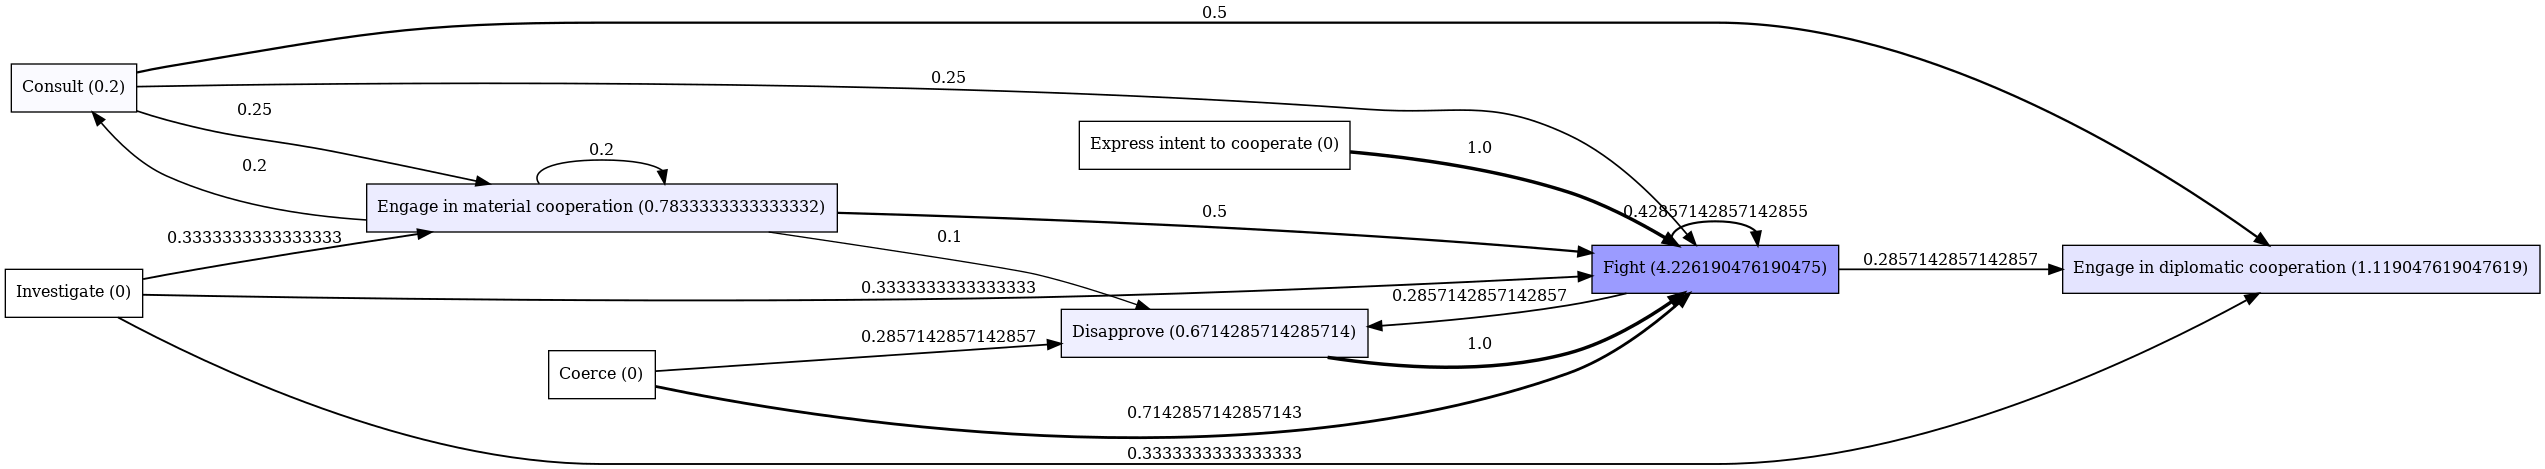

{('Investigate', 'Fight'): 0.3333333333333333, ('Investigate', 'Engage in diplomatic cooperation'): 0.3333333333333333, ('Investigate', 'Engage in material cooperation'): 0.3333333333333333, ('Consult', 'Engage in diplomatic cooperation'): 0.5, ('Consult', 'Engage in material cooperation'): 0.25, ('Consult', 'Fight'): 0.25, ('Disapprove', 'Fight'): 1.0, ('Engage in material cooperation', 'Fight'): 0.5, ('Fight', 'Fight'): 0.42857142857142855, ('Express intent to cooperate', 'Fight'): 1.0, ('Fight', 'Disapprove'): 0.2857142857142857, ('Engage in material cooperation', 'Engage in material cooperation'): 0.2, ('Engage in material cooperation', 'Consult'): 0.2, ('Engage in material cooperation', 'Disapprove'): 0.1, ('Coerce', 'Disapprove'): 0.2857142857142857, ('Coerce', 'Fight'): 0.7142857142857143, ('Fight', 'Engage in diplomatic cooperation'): 0.2857142857142857}


In [46]:
#selector block, config and select stuff here

unprocessed_event_log = import_csv(dataPath)
#event_log = preprocess(unprocessed_event_log,key="USADEU", start_date="1960-01-01", end_date="2000-01-01")

#print(event_log)


#example dfg call
#dfg = make_dfg(event_log,
#            max_path_denoise=False, minThresh=0.2, show=True, 
#            normalize=True, normalize_to="source")
#example efg call
#efg = make_efg(event_log,
#            max_path_denoise=False, minThresh=0.2, show=True, 
#            normalize=True, normalize_to="source", daysFollow=3)
#example manual dfg construction
#dfg, start_activities, end_activities = pm4py.discover_dfg(event_log) #for efg; efg = get_eventually_follows_in_days_graph(event_log, daysFollow)
#dfg = normalize_dfg_to(dfg, normalize_to="source")
#dfg = minthreshold_dfg(dfg, 0.2)
#pm4py.view_dfg(dfg, start_activities=None, end_activities=None, format='png')


#get actopm reaction graph
efg_ar = get_action_reaction_graph(unprocessed_event_log, daysFollow=20, source_country="ISR", target_country="PSE")
efg_ar = normalize_dfg_to(efg_ar, normalize_to="source")
efg_ar = minthreshold_dfg(efg_ar, 0.)
pm4py.view_dfg(efg_ar, start_activities=None, end_activities=None, format='png')

print(efg_ar)
